### Env Setting

In [67]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as sm
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel, ExpSineSquared, DotProduct
from pylab import rcParams
np.random.seed(42)

### Loading Taxi dataset

In [68]:
# Loading Taxi Dataset
old = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/old_taxi.csv")
new = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/new_taxi.csv")

# converting pickup_datetime to datetime object
for df in [old, new]:
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    
old = old.set_index('pickup_datetime')
new = new.set_index('pickup_datetime')

print("Checking datatype:\n")
print(old.info())

Checking datatype:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2008 entries, 2015-01-01 to 2020-06-30
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  2008 non-null   int64  
 1   trip_distance    2008 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 47.1 KB
None


### Plotting - Raw Data

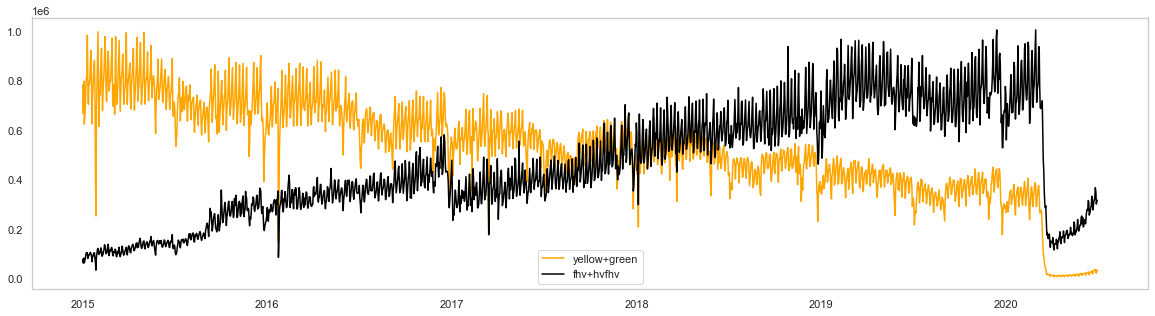

In [69]:
plt.figure(figsize=(20,5))
plt.plot(old.passenger_count, color='orange', label="yellow+green")
plt.plot(new.passenger_count, color='black', label="fhv+hvfhv")
plt.legend()
plt.grid()
plt.show()

# ARMA

### Old Taxi Analysis

### Split into preCovid_training / preCovid_test / postCovid

In [70]:
df = old.copy()

In [71]:
# preCovid // postCovid
preCovid = df.loc[:'2020-02-29']
postCovid = df.loc['2020-03-01':]

In [72]:
# train / test
train = preCovid[:'2019-10-31']
test = preCovid['2019-11-01':]

In [73]:
# normalization
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()
scaler.fit(train['passenger_count'].values.reshape(-1,1))
train['scaled_count'] = scaler.transform(train['passenger_count'].values.reshape(-1,1))
test['scaled_count'] = scaler.transform(test['passenger_count'].values.reshape(-1,1))
preCovid['scaled_count'] = scaler.transform(preCovid['passenger_count'].values.reshape(-1,1))
postCovid['scaled_count'] = scaler.transform(postCovid['passenger_count'].values.reshape(-1,1))

### Plotting ACF, PACF

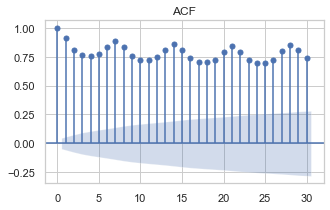

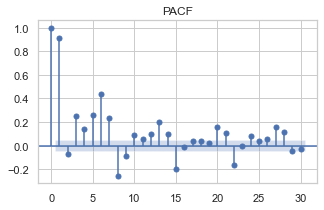

In [74]:
rcParams['figure.figsize'] = 5, 3
lag = len(train) -1
plot_acf(x=train['scaled_count'], lags=30, title='ACF')  ## ACF plots shows strong seasonality
plt.show()
plot_pacf(x=train['scaled_count'], lags=30, title='PACF')
plt.show()

### Seasonal Decomposition Using Train

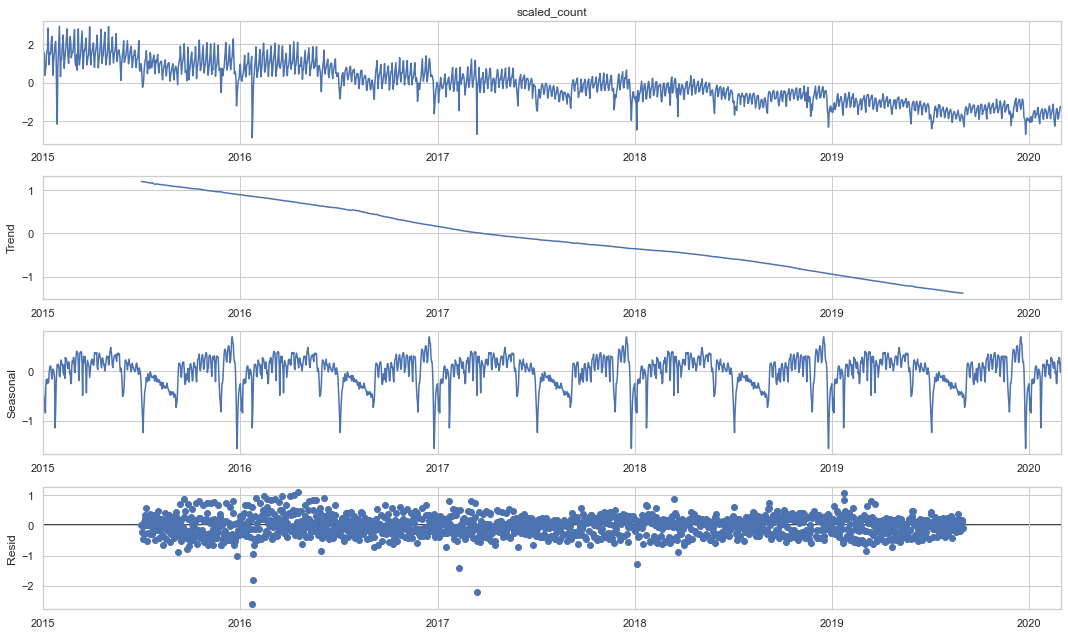

In [75]:
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
rcParams['figure.figsize'] = 15, 9
preCovid_decompose = seasonal_decompose(preCovid['scaled_count'], model='additive', freq=365)
preCovid_decompose.plot()
plt.show()

In [76]:
decomposed_df = pd.DataFrame({"observed": preCovid_decompose.observed, "trend": preCovid_decompose.trend, \
                              "seasonal": preCovid_decompose.seasonal, "resid": preCovid_decompose.resid})

In [77]:
linreg = LinearRegression()
linreg.fit(np.arange(len(train)).reshape(-1, 1), train['scaled_count'].values.reshape(-1, 1))
trend = linreg.predict(np.arange(len(preCovid)).reshape(-1, 1))
decomposed_df['trend'] = trend
decomposed_df['resid'] = decomposed_df['observed'] - decomposed_df['trend'] - decomposed_df['seasonal']
decomposed_df

,observed,trend,seasonal,resid
pickup_datetime,,,,
2015-01-01,1.454445,1.508042,-0.251114,0.197517
2015-01-02,0.664924,1.506332,-0.490109,-0.351298
2015-01-03,1.561054,1.504622,-0.804430,0.860862
2015-01-04,0.373384,1.502912,-0.545909,-0.583619
2015-01-05,0.607001,1.501203,-0.845936,-0.048266
...,...,...,...,...
2020-02-25,-1.546204,-1.708088,0.285407,-0.123523
2020-02-26,-1.512549,-1.709798,0.263106,-0.065857
2020-02-27,-1.250220,-1.711508,0.000843,0.460444


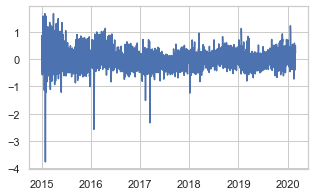

In [78]:
rcParams['figure.figsize'] = 5, 3
plt.plot(decomposed_df['resid'])
plt.show()

In [79]:
train_resid = decomposed_df['resid'][:'2019-10-31']
test_resid = decomposed_df['resid']['2019-11-01':]
train_resid

pickup_datetime
2015-01-01    0.197517
2015-01-02   -0.351298
2015-01-03    0.860862
2015-01-04   -0.583619
2015-01-05   -0.048266
                ...   
2019-10-27   -0.336991
2019-10-28   -0.442481
2019-10-29   -0.237996
2019-10-30   -0.143183
2019-10-31    0.238227
Name: resid, Length: 1765, dtype: float64

### Fitting ARIMA

In [80]:
# import warnings
# warnings.filterwarnings("ignore")
# mse_list = []
# for i in range(10):
#     arima = ARIMA(train_resid, order=(i,0,0), freq='D')
#     arima_res = arima.fit()
#     mse_list.append(mean_squared_error(train_resid, arima_res.fittedvalues))
#     print(f'>>> p = {i}, mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

In [81]:
# plt.figure(figsize=(5,3))
# plt.plot(mse_list, marker='o')
# plt.show()
# print("Plateau around p=7")

In [82]:
# ma_mse_list = []
# for i in range(10):
#     arima = ARIMA(train_resid, order=(7,0,i), freq='D')
#     arima_res = arima.fit()
#     ma_mse_list.append(mean_squared_error(train_resid, arima_res.fittedvalues))
#     print(f'>>> q = {i}, mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

In [83]:
# plt.figure(figsize=(5,3))
# plt.plot(ma_mse_list, marker='o')
# plt.show()
# print("Plateau around p=5")

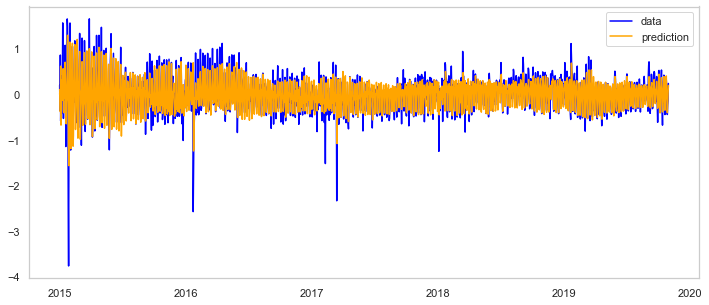

>>> mean_squared_error: 0.060687341157783084


In [84]:
arima = ARIMA(train_resid, order=(7,0,5), freq='D')
arima_res = arima.fit()
plt.figure(figsize=(12,5))
plt.plot(train_resid, color='blue', label="data")
plt.plot(arima_res.fittedvalues, color='orange', label="prediction")
plt.legend()
plt.grid()
plt.show()
print(f'>>> mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

In [85]:
test_trend_pred = linreg.predict(np.arange(start=len(train), stop=len(train)+len(test)).reshape(-1,1)).reshape(-1)
test_seasonality = preCovid_decompose.seasonal['2019-11-01':'2020-02-29'].values
test_resid_pred = arima_res.predict(start='2019-11-01', end='2020-02-29')  # excluding NaN
test_pred = test_trend_pred + test_seasonality + test_resid_pred
print(f'Test set MSE: {mean_squared_error(test.scaled_count, test_pred)}')

Test set MSE: 0.0839357290562829


In [86]:
post_trend_pred = linreg.predict(np.arange(start=len(preCovid), stop=len(df)).reshape(-1,1)).reshape(-1)
post_seasonality = decomposed_df.seasonal['2019-03-03':'2019-07-02'].values
post_resid_pred = arima_res.predict(start='2020-03-01', end='2020-06-30')  # excluding NaN
post_pred = post_trend_pred + post_seasonality + post_resid_pred
pd.DataFrame({'trend': post_trend_pred, 'seasonal': post_seasonality, 'resid': post_resid_pred, 'prediction': post_pred})

,trend,seasonal,resid,prediction
2020-03-01,-1.716637,0.413234,-0.237672,-1.541075
2020-03-02,-1.718347,0.361906,-0.323911,-1.680352
2020-03-03,-1.720057,0.376891,-0.170667,-1.513833
2020-03-04,-1.721767,0.158988,0.011745,-1.551034
2020-03-05,-1.723476,-0.185999,0.234616,-1.674859
...,...,...,...,...
2020-06-26,-1.916684,0.010483,0.320750,-1.585450
2020-06-27,-1.918393,-0.031631,0.104127,-1.845897
2020-06-28,-1.920103,-0.171261,-0.221048,-2.312412
2020-06-29,-1.921813,-0.442497,-0.281529,-2.645839


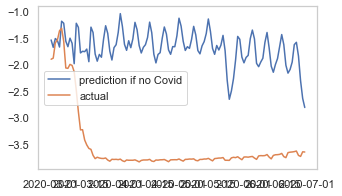

PostCovid MSE: 3.8800692777330643


In [87]:
plt.plot(post_pred, label="prediction if no Covid")
plt.plot(postCovid['scaled_count'], label="actual")
plt.legend()
plt.grid()
plt.show()
print(f'PostCovid MSE: {mean_squared_error(postCovid.scaled_count, post_pred)}')

### New Taxi Analysis

In [91]:
df = new.copy()

In [92]:
# preCovid // postCovid
preCovid = df.loc[:'2020-02-29']
postCovid = df.loc['2020-03-01':]

In [93]:
# train / test
train = preCovid[:'2019-10-31']
test = preCovid['2019-11-01':]

In [94]:
# normalization
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()
scaler.fit(train['passenger_count'].values.reshape(-1,1))
train['scaled_count'] = scaler.transform(train['passenger_count'].values.reshape(-1,1))
test['scaled_count'] = scaler.transform(test['passenger_count'].values.reshape(-1,1))
preCovid['scaled_count'] = scaler.transform(preCovid['passenger_count'].values.reshape(-1,1))
postCovid['scaled_count'] = scaler.transform(postCovid['passenger_count'].values.reshape(-1,1))

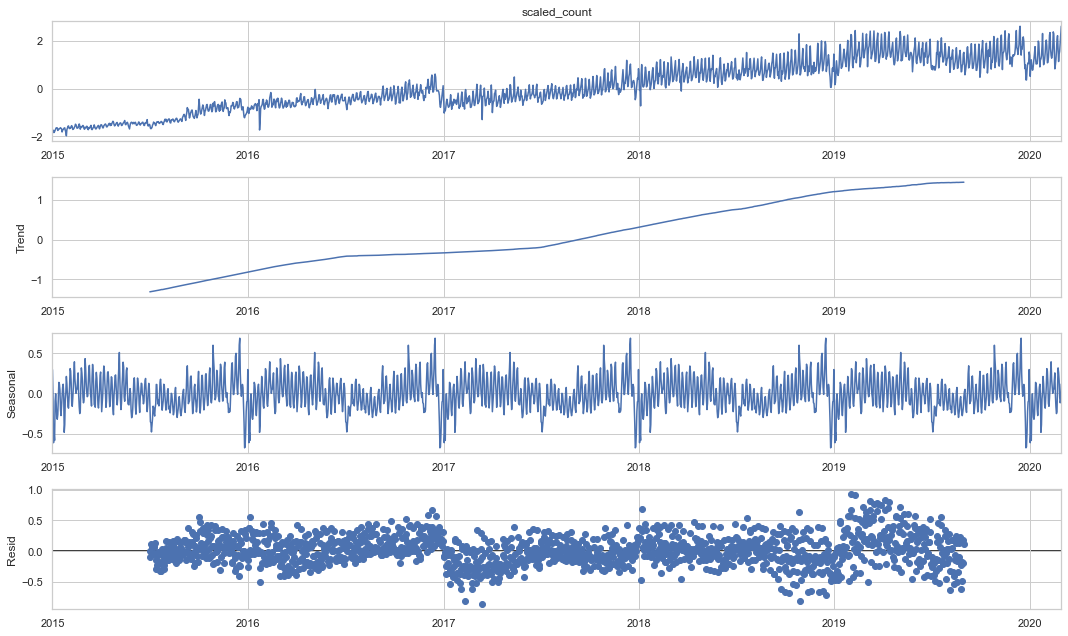

In [95]:
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
rcParams['figure.figsize'] = 15, 9
preCovid_decompose = seasonal_decompose(preCovid['scaled_count'], model='additive', freq=365)
preCovid_decompose.plot()
plt.show()

In [96]:
decomposed_df = pd.DataFrame({"observed": preCovid_decompose.observed, "trend": preCovid_decompose.trend, \
                              "seasonal": preCovid_decompose.seasonal, "resid": preCovid_decompose.resid})

In [97]:
linreg = LinearRegression()
linreg.fit(np.arange(len(train)).reshape(-1, 1), train['scaled_count'].values.reshape(-1, 1))
trend = linreg.predict(np.arange(len(preCovid)).reshape(-1, 1))
decomposed_df['trend'] = trend
decomposed_df['resid'] = decomposed_df['observed'] - decomposed_df['trend'] - decomposed_df['seasonal']
decomposed_df

,observed,trend,seasonal,resid
pickup_datetime,,,,
2015-01-01,-1.776930,-1.622782,0.296428,-0.450576
2015-01-02,-1.852597,-1.620942,-0.045790,-0.185865
2015-01-03,-1.757175,-1.619102,-0.612311,0.474238
2015-01-04,-1.848524,-1.617262,-0.486957,0.255696
2015-01-05,-1.808824,-1.615422,-0.583564,0.390163
...,...,...,...,...
2020-02-25,1.449640,1.838049,0.156670,-0.545079
2020-02-26,1.563811,1.839889,-0.047624,-0.228453
2020-02-27,1.914974,1.841729,-0.116672,0.189918


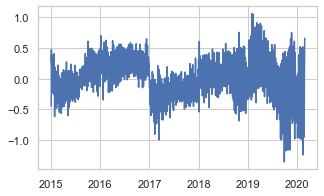

In [98]:
rcParams['figure.figsize'] = 5, 3
plt.plot(decomposed_df['resid'])
plt.show()

In [99]:
train_resid = decomposed_df['resid'][:'2019-10-31']
test_resid = decomposed_df['resid']['2019-11-01':]
train_resid

pickup_datetime
2015-01-01   -0.450576
2015-01-02   -0.185865
2015-01-03    0.474238
2015-01-04    0.255696
2015-01-05    0.390163
                ...   
2019-10-27   -0.399258
2019-10-28   -1.171590
2019-10-29   -0.815845
2019-10-30   -0.516204
2019-10-31    0.032397
Name: resid, Length: 1765, dtype: float64

In [31]:
import warnings
warnings.filterwarnings("ignore")
mse_list = []
for i in range(10):
    arima = ARIMA(train_resid, order=(i,0,0), freq='D')
    arima_res = arima.fit()
    mse_list.append(mean_squared_error(train_resid, arima_res.fittedvalues))
    print(f'>>> p = {i}, mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

>>> p = 0, mean_squared_error: 0.09083397189232559
>>> p = 1, mean_squared_error: 0.048654870080183425
>>> p = 2, mean_squared_error: 0.0444009246474781
>>> p = 3, mean_squared_error: 0.042850472620596915
>>> p = 4, mean_squared_error: 0.042762848991357474
>>> p = 5, mean_squared_error: 0.03870344767322611
>>> p = 6, mean_squared_error: 0.025557120368741245
>>> p = 7, mean_squared_error: 0.020071000445592034
>>> p = 8, mean_squared_error: 0.01976335290065314
>>> p = 9, mean_squared_error: 0.01964231236283439


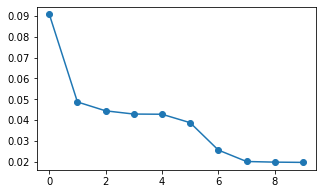

Plateau around p=7


In [32]:
plt.figure(figsize=(5,3))
plt.plot(mse_list, marker='o')
plt.show()
print("Plateau around p=7")

In [33]:
ma_mse_list = []
for i in range(10):
    arima = ARIMA(train_resid, order=(7,0,i), freq='D')
    arima_res = arima.fit()
    ma_mse_list.append(mean_squared_error(train_resid, arima_res.fittedvalues))
    print(f'>>> q = {i}, mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

>>> q = 0, mean_squared_error: 0.020071000445592034
>>> q = 1, mean_squared_error: 0.019851804707946116
>>> q = 2, mean_squared_error: 0.019616930086029383
>>> q = 3, mean_squared_error: 0.019078269182396735
>>> q = 4, mean_squared_error: 0.017911062911117145
>>> q = 5, mean_squared_error: 0.018049199654735774
>>> q = 6, mean_squared_error: 0.01629817809593602
>>> q = 7, mean_squared_error: 0.01651668263795933
>>> q = 8, mean_squared_error: 0.016810425297999122
>>> q = 9, mean_squared_error: 0.016160068106541976


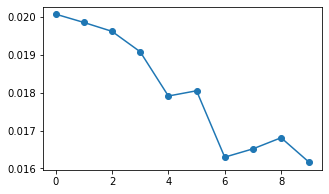

Plateau around p=6


In [34]:
plt.figure(figsize=(5,3))
plt.plot(ma_mse_list, marker='o')
plt.show()
print("Plateau around p=6")

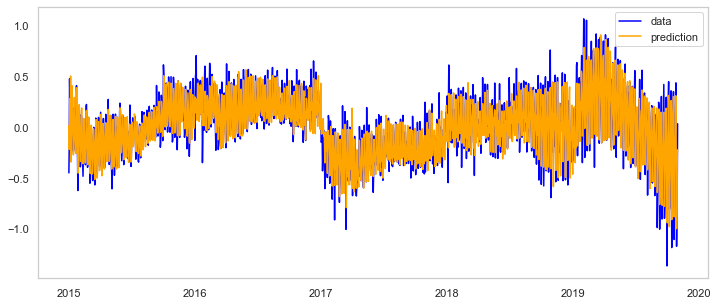

>>> mean_squared_error: 0.01629817809593602


In [100]:
arima = ARIMA(train_resid, order=(7,0,6), freq='D')
arima_res = arima.fit()
plt.figure(figsize=(12,5))
plt.plot(train_resid, color='blue', label="data")
plt.plot(arima_res.fittedvalues, color='orange', label="prediction")
plt.legend()
plt.grid()
plt.show()
print(f'>>> mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

In [101]:
test_trend_pred = linreg.predict(np.arange(start=len(train), stop=len(train)+len(test)).reshape(-1,1)).reshape(-1)
test_seasonality = preCovid_decompose.seasonal['2019-11-01':'2020-02-29'].values
test_resid_pred = arima_res.predict(start='2019-11-01', end='2020-02-29')  # excluding NaN
test_pred = test_trend_pred + test_seasonality + test_resid_pred
print(f'Test set MSE: {mean_squared_error(test.scaled_count, test_pred)}')

Test set MSE: 0.08833338774035285


In [102]:
post_trend_pred = linreg.predict(np.arange(start=len(preCovid), stop=len(df)).reshape(-1,1)).reshape(-1)
post_seasonality = decomposed_df.seasonal['2019-03-03':'2019-07-02'].values
post_resid_pred = arima_res.predict(start='2020-03-01', end='2020-06-30')  # excluding NaN
post_pred = post_trend_pred + post_seasonality + post_resid_pred
pd.DataFrame({'trend': post_trend_pred, 'seasonal': post_seasonality, 'resid': post_resid_pred, 'prediction': post_pred})

,trend,seasonal,resid,prediction
2020-03-01,1.847248,0.313151,-0.170580,1.989820
2020-03-02,1.849088,0.134133,-0.761478,1.221743
2020-03-03,1.850928,0.017705,-0.542715,1.325919
2020-03-04,1.852768,-0.040826,-0.102580,1.709362
2020-03-05,1.854608,-0.031771,0.038961,1.861797
...,...,...,...,...
2020-06-26,2.062515,0.027320,0.284530,2.374366
2020-06-27,2.064355,0.125270,0.420327,2.609952
2020-06-28,2.066195,0.060358,-0.084653,2.041900
2020-06-29,2.068035,-0.122742,-0.618312,1.326981


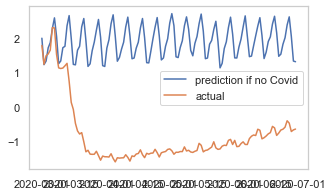

PostCovid MSE: 8.451308535755238


In [103]:
plt.plot(post_pred, label="prediction if no Covid")
plt.plot(postCovid['scaled_count'], label="actual")
plt.legend()
plt.grid()
plt.show()
print(f'PostCovid MSE: {mean_squared_error(postCovid.scaled_count, post_pred)}')

### Kalman Filtering

In [4]:
def plot_kalman(time, latent, data, ky=None, ky_var=None, plot_type="r-", label=None, title='sample'):
    """
    Plot the trajectory
    """
    x, y = time, latent
    nx, ny = data[:, 0], data[:, 1]
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    if ky is not None:
        ax[0].plot(x, y, 'g-', time, nx, 'b.', time, ny, 'b.', time, ky, 'r-', plot_type)
        if ky_var is not None:
            ax[0].fill_between(time, ky - np.sqrt(ky_var),
                               ky + np.sqrt(ky_var), color='r', alpha=.5, label='estimate')
        ax[0].legend()
        ax[1].plot(y, ky, '.', color='grey')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        ax[1].set_title('cc %.3f' %(np.corrcoef(y[:,0], ky)[0,1]))
    else:
        ax[0].plot(x, y, 'g-', x, nx, 'b.', x, ny, 'b.')

        ax[1].plot(y, nx, '.k', label='observed dim 1')
        ax[1].plot(y, ny, '.', color='grey', label='observed dim 2')
        ax[1].set_xlabel('latent')
        ax[1].set_ylabel('observed')
        ax[1].legend()

    ax[0].set_xlabel('time')
    ax[0].set_ylabel('latent')
    ax[0].set_title(title)
    ax[1].set_aspect(1)

    return fig

# Kalman Filter

### Old Taxi Analysis

In [5]:
df = old.copy()

In [6]:
# preCovid // postCovid
preCovid = df.loc[:'2020-02-29']
postCovid = df.loc['2020-03-01':]

In [7]:
# train / test
train = preCovid[:'2019-10-31']
test = preCovid['2019-11-01':]

In [8]:
# normalization
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()
scaler.fit(train['passenger_count'].values.reshape(-1,1))
train['scaled_count'] = scaler.transform(train['passenger_count'].values.reshape(-1,1))
test['scaled_count'] = scaler.transform(test['passenger_count'].values.reshape(-1,1))
preCovid['scaled_count'] = scaler.transform(preCovid['passenger_count'].values.reshape(-1,1))
postCovid['scaled_count'] = scaler.transform(postCovid['passenger_count'].values.reshape(-1,1))

In [9]:
n_dim_state = 1
n_dim_obs = 1
kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, 
                  transition_matrices = np.eye(n_dim_state), 
                  transition_covariance = np.eye(n_dim_state), 
                  observation_matrices = np.eye(n_dim_obs, n_dim_state),
                  observation_covariance = np.eye(n_dim_obs),
                  initial_state_mean = np.zeros(n_dim_state), 
                  initial_state_covariance = np.eye(n_dim_state),
                  random_state=42)
kf = kf.em(train['scaled_count'], n_iter=10, em_vars='all')

In [10]:
filtered_mean, filtered_cov = kf.filter(train['scaled_count'])
smoothed_mean, smoothed_cov = kf.smooth(train['scaled_count'])

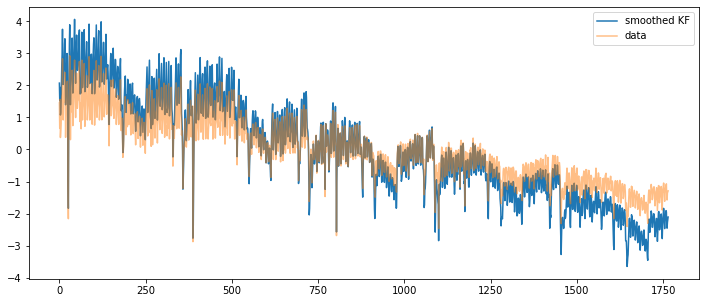

>>> train mean_squared_error: 0.3603243367094232


In [11]:
plt.figure(figsize=(12,5))
plt.plot(smoothed_mean, label="smoothed KF")
plt.plot(train['scaled_count'].values, label="data", alpha=0.5)
plt.legend()
plt.show()
print(f'>>> train mean_squared_error: {mean_squared_error(train.scaled_count, smoothed_mean)}')

In [12]:
A = kf.transition_matrices.reshape(-1)
Q = kf.transition_covariance.reshape(-1)
C = kf.observation_matrices.reshape(-1)
R = kf.observation_covariance.reshape(-1)

In [13]:
np.random.seed(seed=42)
mean_list = [float(smoothed_mean[-1])]
for i in range(1, len(test)+len(postCovid)+1):
    next_mean = C * (A**i) * mean_list[0] 
    mean_list.append(float(next_mean))
    
cov_list = [float(smoothed_cov[-1])]
for i in range(1, len(test)+len(postCovid)+1):
    aqa_sum = np.sum([A**m * Q * A**m for m in range(i)])
    next_cov = C * (A**i * cov_list[0] * A**i + aqa_sum) * C + R
    cov_list.append(float(next_cov))

In [14]:
pred_list = []
for mean, cov in zip(mean_list, cov_list):
    pred_list.append(np.random.normal(mean, np.sqrt(cov), 1))

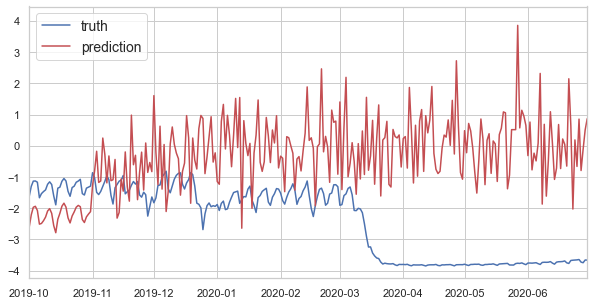

>>> train mean_squared_error: 0.3603243367094232
>>> test_mean_squared_error: 2.6996592081249107
>>> postCovid_mean_squared_error: 14.59498960336788


In [23]:
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
plt.figure(figsize=(10,5))
plt.plot(df.index, pd.concat([train.scaled_count, test.scaled_count, postCovid.scaled_count]), label="truth", color='b')
plt.plot(df.index, np.append(smoothed_mean, pred_list[1:]), label="prediction", color='r')
plt.legend(fontsize=14)
plt.xlim('2019-10-01', '2020-06-30')
plt.savefig('KF.png', transparent=True)
plt.show()
print(f'>>> train mean_squared_error: {mean_squared_error(train.scaled_count, smoothed_mean)}')
print(f'>>> test_mean_squared_error: {mean_squared_error(test.scaled_count, pred_list[1:len(test)+1])}')
print(f'>>> postCovid_mean_squared_error: {mean_squared_error(postCovid.scaled_count, pred_list[len(test)+1:])}')

### New Taxi Analysis

In [79]:
df = new.copy()

In [80]:
# preCovid // postCovid
preCovid = df.loc[:'2020-02-29']
postCovid = df.loc['2020-03-01':]

In [81]:
# train / test
train = preCovid[:'2019-10-31']
test = preCovid['2019-11-01':]

In [82]:
# normalization
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()
scaler.fit(train['passenger_count'].values.reshape(-1,1))
train['scaled_count'] = scaler.transform(train['passenger_count'].values.reshape(-1,1))
test['scaled_count'] = scaler.transform(test['passenger_count'].values.reshape(-1,1))
preCovid['scaled_count'] = scaler.transform(preCovid['passenger_count'].values.reshape(-1,1))
postCovid['scaled_count'] = scaler.transform(postCovid['passenger_count'].values.reshape(-1,1))

In [83]:
n_dim_state = 1
n_dim_obs = 1
kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, 
                  transition_matrices = np.eye(n_dim_state), 
                  transition_covariance = np.eye(n_dim_state), 
                  observation_matrices = np.eye(n_dim_obs, n_dim_state),
                  observation_covariance = np.eye(n_dim_obs),
                  initial_state_mean = np.zeros(n_dim_state), 
                  initial_state_covariance = np.eye(n_dim_state),
                  random_state=42)
kf = kf.em(train['scaled_count'], n_iter=10, em_vars='all')

In [84]:
filtered_mean, filtered_cov = kf.filter(train['scaled_count'])
smoothed_mean, smoothed_cov = kf.smooth(train['scaled_count'])

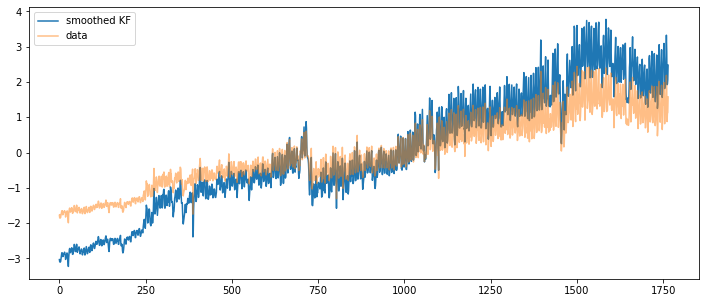

>>> train mean_squared_error: 0.46432477695389063


In [85]:
plt.figure(figsize=(12,5))
plt.plot(smoothed_mean, label="smoothed KF")
plt.plot(train['scaled_count'].values, label="data", alpha=0.5)
plt.legend()
plt.show()
print(f'>>> train mean_squared_error: {mean_squared_error(train.scaled_count, smoothed_mean)}')

In [86]:
A = kf.transition_matrices.reshape(-1)
Q = kf.transition_covariance.reshape(-1)
C = kf.observation_matrices.reshape(-1)
R = kf.observation_covariance.reshape(-1)

In [87]:
np.random.seed(seed=42)
mean_list = [float(smoothed_mean[-1])]
for i in range(1, len(test)+len(postCovid)+1):
    next_mean = C * (A**i) * mean_list[0] 
    mean_list.append(float(next_mean))
    
cov_list = [float(smoothed_cov[-1])]
for i in range(1, len(test)+len(postCovid)+1):
    aqa_sum = np.sum([A**m * Q * A**m for m in range(i)])
    next_cov = C * (A**i * cov_list[0] * A**i + aqa_sum) * C + R
    cov_list.append(float(next_cov))

In [88]:
pred_list = []
for mean, cov in zip(mean_list, cov_list):
    pred_list.append(np.random.normal(mean, np.sqrt(cov), 1))

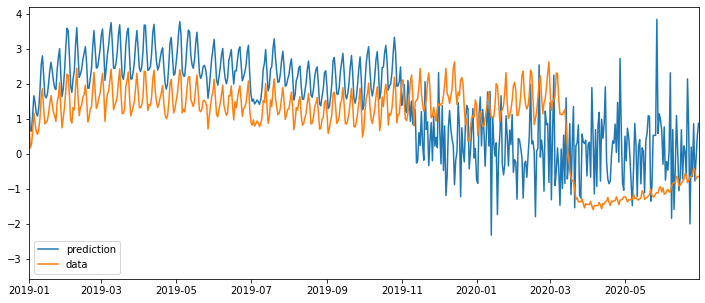

>>> train mean_squared_error: 0.46432477695389063
>>> test_mean_squared_error: 2.348809302466722
>>> postCovid_mean_squared_error: 2.7412214365977454


In [89]:
plt.figure(figsize=(12,5))
plt.plot(df.index, np.append(smoothed_mean, pred_list[1:]), label="prediction")
plt.plot(df.index, pd.concat([train.scaled_count, test.scaled_count, postCovid.scaled_count]), label="data")
plt.legend()
plt.xlim('2019-01-01', '2020-06-30')
plt.show()
print(f'>>> train mean_squared_error: {mean_squared_error(train.scaled_count, smoothed_mean)}')
print(f'>>> test_mean_squared_error: {mean_squared_error(test.scaled_count, pred_list[1:len(test)+1])}')
print(f'>>> postCovid_mean_squared_error: {mean_squared_error(postCovid.scaled_count, pred_list[len(test)+1:])}')